In [1]:
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
# sys.path.insert(1, '/Users/cholak/Work/EPFL/tp4/ECAL/fall22/summer_studs_work/Ecal2022/Analyse/Track_reconstruction')
# sys.path.insert(1, '/Users/cholak/Work/EPFL/tp4/ECAL/fall22/ecal_reco_soft/ecal_reco')


# import track_reconstruction as tr


In [2]:
import os
## configure your env by adding these vars:
# conda env config vars set ECAL_CODE=/Users/cholak/Work/EPFL/tp4/ECAL/fall22/ecal_reco_soft/ecal_reco
#conda env config vars set ECAL_DATA=/Users/cholak/Work/EPFL/tp4/ECAL/fall22/summer_studs_work/Ecal2022/datasets


In [8]:
## run this to be able to load our modules
import sys
sys.path.insert(1, '/Users/cholak/Work/EPFL/tp4/ECAL/fall22/ecal_reco_soft/ecal_reco')
## or add directory with our software to the PYTHONPATH, then every time you run python ecal_reco package will be awailable for import
# export PYTHONPATH="${PYTHONPATH}:/Users/cholak/Work/EPFL/tp4/ECAL/fall22/ecal_reco_soft/ecal_reco" ## run this in terminal



In [6]:
%%bash 
export PYTHONPATH="${PYTHONPATH}:/Users/cholak/Work/EPFL/tp4/ECAL/fall22/ecal_reco_soft/ecal_reco"

In [9]:
import tracking.track_reconstruction as tr
from utils.data_loading import load_dataset

In [3]:
data_path =  os.environ['ECAL_DATA']
file_path = '/Users/cholak/Work/EPFL/tp4/ECAL/fall22/summer_studs_work/Ecal2022/datasets/10h/data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing


df_hits = load_dataset(file_path)
df_hits.query('n_hits > 2', inplace=True)

In [166]:
def dr(hit_ref, hits):
    ## eval array of vectors connecting all hits with ref hit
    dr = hits - hit_ref

    # dr_u =  np.abs(dr[:,1])
    # dr_d =  np.abs(dr[:,0])
    ## projections
    dr_u =  dr[:,1]
    dr_d =  dr[:,0]
    ## eval module
    dr_mod =  np.sqrt(dr_u*dr_u + dr_d*dr_d)
    return dr_mod

In [212]:
def create_tracks(df):
    new_cols = ['index_x','index_y','track_param','track_id', 'hitsX','hitsY', 'track_mean_time', 'track_hitX', 'track_hitY', 'track_last_hitX', 'track_last_hitY']
    for col in new_cols:
        df[col] = None
    nb_events=len(df['n_hits'])
    steps=9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in df.iterrows():
        print('Event number: '+str(index)+' over '+str(nb_events))
        channels=row['tofpet_channel']
        tofpet_id=row['tofpet_id']
        # print(tofpet_id)
        hitsX=[tr.mapping_2D(tofpet_id[hits],channels[hits]) for hits in range(len(channels)) if tr.is_sidex(tofpet_id[hits])]
        hitsY=[tr.mapping_2D(tofpet_id[hits],channels[hits]) for hits in range(len(channels)) if not(tr.is_sidex(tofpet_id[hits]))]
        index_x=[hits for hits in range(len(channels)) if tr.is_sidex(tofpet_id[hits])] # index we need for the time calibration
        index_y=[hits for hits in range(len(channels)) if not(tr.is_sidex(tofpet_id[hits]))]# index we need for the time calibration
        if len(hitsX)>1 and len(hitsY)>1: ## Some events don't have hits on one of the two sides and are thus not considered
            x0,tx,hits_index=tr.tracks(hitsX)
            y0,ty,hits_indey=tr.tracks(hitsY)

            # print(hitsX) ## mapped coordinate of the hit (tofpet ch -> calo cell nb (nX, nZ) or)
            # print(hits_index) ## index of the hit that belongs to the track (applied to array above)
            # print(index_x) ## mapping back of the hitsX array to the indexes of hits in original df

            # print(hitsY)
            # print(hits_indey)
            # print(index_y)

            steps=9
            z=np.linspace(1,9,steps)
            x=tx*(z-9)*2+x0
            y=ty*(z-9)*2+y0
            trackx=[[x[i],(z[i]-1)*2] for i in range(steps)]## Track projection on X
            tracky=[[y[i],(z[i]-1)*2] for i in range(steps)] ## Track projection on Y

            ## Chi_2 test for the tracks determined before
            chix=tr.chi_2(hitsX,trackx,hits_index)
            chiy=tr.chi_2(hitsY,tracky,hits_indey)

    ####   Updating df with reconstructed tracks and hits  #####
            df.at[index,'hitsX'] = hitsX
            df.at[index,'hitsY'] = hitsY

            ## check if track has a "good" chi2 value
            if chix and chiy:
            # if True:
                for col, val in zip(['index_x','index_y','track_param','track_id'], [index_x,index_y,[x0,tx,y0,ty],index]):
                    df.at[index,col] = val
                
                ## find indeces of the hitsX and hitsY arrays that are belonging to the track
                track_hitX_idxes = np.array(index_x)[hits_index]
                track_hitY_idxes = np.array(index_y)[hits_indey]
  
                ## save hits corresponding to the track
                track_hitX = np.array(hitsX)[hits_index]
                track_hitY = np.array(hitsY)[hits_indey]
                df.at[index,'track_hitX'] = track_hitX
                df.at[index,'track_hitY'] = track_hitY

                track_indexes = np.concatenate([track_hitX_idxes, track_hitY_idxes])
                ## calculate the mean time of the track
                track_mean_time = row['timestamp_global'] + np.mean(np.array(row['timestamp'])[track_indexes])
                ## save coordinate of the last hit (deepest by dZ)
                maxZ_idx = track_hitX.argmax(axis=0)[1]
                track_last_hitX = track_hitX[maxZ_idx]
                maxZ_idx = track_hitY.argmax(axis=0)[1]
                track_last_hitY = track_hitY[maxZ_idx]
                df.at[index,'track_last_hitX'] = track_last_hitX
                df.at[index,'track_last_hitY'] = track_last_hitY

                df.at[index,'track_mean_time'] = track_mean_time
                ## set the starting point of the time count 
                buff_start = track_mean_time
                ## check if the track does not penetrate the whole calo:
                if (track_last_hitX[1] < 8 ) and (track_last_hitY[1] < 8 ):
                    buff_evt_idx = index
            else:
                print('A track was not satisfying')
            ## check if the event does not have a track and it's not the first entry in df
            # if buff_start is not None and track_mean_time is None:
            if (buff_start is not None) and (buff_evt_idx is not None) and (df.at[index,'track_mean_time'] is  None):
                
                ## and if there are hits close to the end point 
                distances_XZ = dr(df.at[buff_evt_idx,'track_last_hitX'], hitsX) 
                distances_YZ = dr(df.at[buff_evt_idx,'track_last_hitY'], hitsY)
                if np.any(distances_XZ < 2) or np.any(distances_YZ < 2):
                    ## eval timediff
                    dt = row['timestamp_global'] - buff_start
                    dts.append(dt)

                

    return df, dts
    

In [217]:
df_test, dts = create_tracks(df_hits[:10000])

/var/folders/0x/z9z6y7ln6138hr3d9xswrd080000gp/T/ipykernel_59308/4064010214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = None


Event number: 18 over 10000
Event number: 41 over 10000
A track was not satisfying
Event number: 60 over 10000
Event number: 105 over 10000
A track was not satisfying
Event number: 111 over 10000
Event number: 144 over 10000
Event number: 159 over 10000
Event number: 176 over 10000
Event number: 178 over 10000
Event number: 194 over 10000
Event number: 230 over 10000
Event number: 269 over 10000
Event number: 278 over 10000
Event number: 320 over 10000
Event number: 323 over 10000
A track was not satisfying
Event number: 360 over 10000
Event number: 361 over 10000
Event number: 375 over 10000
Event number: 380 over 10000
Event number: 385 over 10000
Event number: 391 over 10000
Event number: 409 over 10000
Event number: 474 over 10000
Event number: 481 over 10000
Event number: 484 over 10000
Event number: 493 over 10000
Event number: 505 over 10000
A track was not satisfying
Event number: 506 over 10000
Event number: 520 over 10000
Event number: 525 over 10000
Event number: 531 over 10

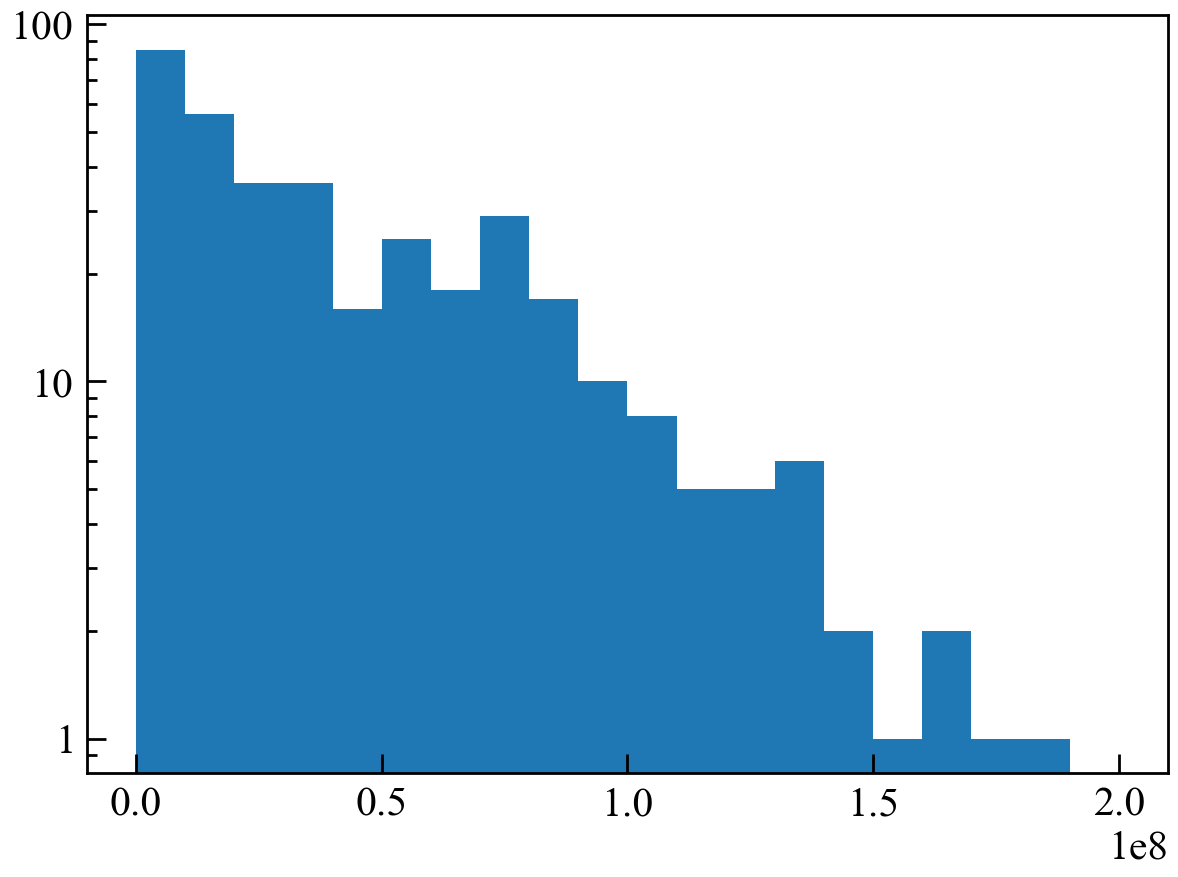

In [233]:
plt.hist(np.array(dts)*6.25, bins = 20, range=(0, 2e8))
plt.yscale('log')

In [242]:
# import sys
# orig_stdout = sys.stdout
# # sys.path.append("/Users/cholak/Work/EPFL/HNL/code/vrd-b2mumupi/codeB2mumupi/anaCode")
# import mplhep as hep
# # plt.style.use([hep.style.LHCb])
# plt.style.use('default')

# from plots import plotFit
# import zfit


In [260]:
#### plotiing and fitting part
import zfit
import sys
import mplhep
from uncertainties import unumpy, ufloat
from scipy.stats import chisquare
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import zfit
from zfit import z as ztf
import matplotlib.patches as mpatches
import math

isDebug = False

def pltdist(data, bins, bounds, norm, y_label = None,  **kwargs):
    
    y, bin_edges = np.histogram(data, bins=bins, range=bounds)
    binwidth = (bounds[1] - bounds[0]) / bins
    if norm: 
        y= y/len(data)
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    yerr = np.sqrt(y)
    if norm: 
        yerr= yerr/ len(data)
    plt.errorbar(bin_centers, y, yerr=yerr, **kwargs)
    if y_label is None:
        y_label = f"Candidates/({binwidth:.2f} [OX unit])"
    plt.ylabel(y_label)


def plotFit(
    pdf,
    data,
    plotList,
    x_label,
    y_label=None,
    nbins=50,
    plot_pull=True,
    logy=False,
    rangeX=None,
    rangeY=None,
    plot_chi2 = False,
    **kwargs):

    _range = rangeX if rangeX else pdf.space.limit1d

    ## data --> histogram
    datay, bin_edges = np.histogram(data, bins=nbins, range=_range)
    errory = np.sqrt(datay)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    binwidth = (_range[1] - _range[0]) / nbins

    ## the pdf normalization
    try:
        integral_pdf = pdf.ext_integrate(_range)
    # except NotExtendedPDFError:
    except AttributeError:
        integral_pdf = pdf.integrate(_range)
    if isDebug: 
        print(f"Integral of extended pdf: N = {integral_pdf}")
        print(f"Integral of  pdf: I = {pdf.integrate(_range)}")
        print("Normalization range", pdf.norm_range)


    if pdf.is_extended:
        N = zfit.run(integral_pdf)
        integral_pdf = integral_pdf / pdf.get_yield()
        if isDebug: print(f"Calculated from extended pdf: N = {N}")
    else:
        N = np.sum(datay)
        if isDebug: print(f"Calculated from datay array: N = {N}")

    norm = N * binwidth
    if isDebug: 
        print(f"Range = {_range}")
        print(f"Norm = {norm}")



    if not rangeY:
        if logy:
            if isDebug: 
                print(min(datay), max(datay))
            rangeY = (min(datay)*0.1 + 1, max(datay) * 10.0)
        else:
            rangeY = (0.01, max(datay) * 1.2)
            # pass

    yscale = "log" if logy else ""

    x = np.linspace(*_range, num=1000)

    # LHCbStyle()

    if plot_pull:
        if kwargs.get("ax1", None) is not None:
            ax1 = kwargs["ax1"]
            f = None
        else:
            f = plt.figure()
            gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.125)
            ax1 = plt.subplot(gs[0])
    else:
        ax1 = kwargs.get("ax1", None)
        if ax1 is None:
            ax1 = plt.gca()
        f = None

    # plot data
    if not "data" in plotList.keys():
        plotList["data"] = {"color": "black", "label": "Data"}
    datacolor = plotList["data"].get("color", "black")
    datalabel = plotList["data"].get("label", "Data")
    mplhep.histplot(
        datay,
        bins=bin_edges,
        label=datalabel,
        ax=ax1,
        histtype="errorbar",
        color=datacolor,
        markersize=4,
        yerr=True,
        elinewidth=1.5,
    )


    # plot model
    if not "fullmodel" in plotList.keys():
        plotList["fullmodel"] = {"color": "blue", "label": "Full model"}
    fmodelcolor = plotList["fullmodel"].get("color", "blue")
    fmodellabel = plotList["fullmodel"].get("label", "Full model")

    try:
        toplot = []
        toresiduals = []
        for i, (m, frac) in enumerate(zip(pdf.get_models(), pdf.fracs)):
            if m.is_extended:
                _frac = (frac / integral_pdf) * (m.ext_integrate(_range) / m.get_yield())
            else:
                _frac = (frac / integral_pdf) * m.integrate(_range)
            y = zfit.run(m.pdf(x, norm_range=_range) * _frac * norm)
            yb = zfit.run(m.pdf(bin_centers, norm_range=_range) * _frac * norm)
            toplot.append(y)
            toresiduals.append(yb)

        _ = ax1.plot(
            x, np.sum(toplot, axis=0), color=fmodelcolor, lw=2, label=fmodellabel
        )

        prop_cycle = plt.rcParams["axes.prop_cycle"]
        colors = prop_cycle.by_key()["color"]

        for i, (m, y) in enumerate(zip(pdf.get_models(), toplot)):
            if not f"model_{i}" in plotList.keys():
                plotList[f"model_{i}"] = {"color": colors[i], "label": f"model_{i}"}
            _color = plotList[f"model_{i}"].get("color", colors[i])
            _label = plotList[f"model_{i}"].get("label", f"model_{i}")
            _ = ax1.plot(x, y, ls="--", color=_color, label=_label)

        pdfy = np.sum(toresiduals, axis=0)

    except AttributeError:
        pdfy = zfit.run(pdf.pdf(bin_centers, norm_range=_range)) * norm
        _ = ax1.plot(
            x,
            zfit.run(pdf.pdf(x, norm_range=_range)) * norm,
            color=fmodelcolor,
            lw=2,
            label=fmodellabel,
        )

    if y_label is None:
        y_label = f"Candidates/({binwidth:.2f} [MeV])"

    ax1.axes.set_ylabel(y_label, ha="right", y=1)
    ax1.axes.set_xlim(_range)
    ax1.axes.set_ylim(rangeY)
    if not plot_pull:
        ax1.axes.set_xlabel(x_label, ha="right", x=1)
    else:
        ax1.set_xticklabels([])

    ax1.minorticks_on()
    ax1.legend(loc="best", fontsize=kwargs.get("fontsize", 20))

    if plot_chi2:
        nfree_params = kwargs.get("nfree_params", len(pdf.get_params(floating = True)))
        # chi2 = chisquare(datay_norm, pdfy_norm, nfree_params)[0]
        chi2 = chisquare_manual(datay, pdfy)
        ndof = nbins - 1 + nfree_params
        chi2ndof = chi2 / ndof
#         ax1.text(
#             0.8,
#             0.4,
#             r"$\chi^{2}$/ndof = " + f"{chi2ndof:.2f}" + f"\n nFree_params = {nfree_params}",
#             transform=ax1.transAxes,
#         )

        # where some data has already been plotted to ax
        handles, labels = ax1.get_legend_handles_labels()

        # manually define a new patch 
        patch = mpatches.Patch(label=r"$\chi^{2}$/ndof = " + f"{chi2ndof:.2f}" + f"\n nFree_params = {nfree_params}")

        # handles is a list, so append manual patch
        handles.append(patch) 
        # plot the legend
        ax1.legend(handles=handles, loc='best')

    ax1.legend(loc="best", fontsize=kwargs.get("fontsize", 20))
    if plot_pull:

        if kwargs.get("ax2", None) is not None:
            ax2 = kwargs["ax2"]
        else:
            ax2 = plt.subplot(gs[1])

        ax2.axes.set_ylim((-5, 5))
        ax2.axes.set_xlim(_range)
        ax2.axes.set_ylabel("Pulls")
        ax2.axes.set_xlabel(x_label, ha="right", x=1)
        ax2.plot(list(_range), [2, 2], color="red", linewidth=1.5, linestyle="-.")
        ax2.plot(list(_range), [-2, -2], color="red", linewidth=1.5, linestyle="-.")
        ax2.plot(list(_range), [0, 0], color="grey", linewidth=1.5, linestyle="-.")

        ax2.minorticks_on()
        datay = unumpy.uarray(datay, errory)
        errory = np.where(datay == 0.0, np.ones(errory.shape), errory)
        pully = (datay - pdfy) / errory
        ax2.errorbar(
            bin_centers,
            unumpy.nominal_values(pully),
            yerr=unumpy.std_devs(pully),
            fmt=".",
            ecolor="Black",
            markersize=4,
            color="Black",
            elinewidth=1.5,
        )
    else:
        ax2 = None

    try:
        f.align_ylabels()
    except (UnboundLocalError, AttributeError):
        pass

    if logy:
        ax1.set_yscale("log", nonposy="clip")

    return f, ax1, ax2

In [254]:
data_np = np.array(dts)*6.25
fit_window = (0.01, 2e8)
## in case params are being recreated multiple times:
ll = np.random.uniform(0,1e3)
Nbkg_1 = zfit.Parameter(f"Nbkg_1_{ll}", 100, 0., 1000, step_size=1)

slope_expo_1 = zfit.Parameter(f"slope_expo_1_{ll}", -1e-8, -1., 1e-10, step_size=0.001)

obs_1 = zfit.Space('mass_1', limits=fit_window)

bkg_pdf_1 = zfit.pdf.Exponential(obs=obs_1,lam = slope_expo_1)
bkg_pdf_ext_1 = bkg_pdf_1.create_extended(Nbkg_1)

data = zfit.data.Data.from_numpy(obs=obs_1, array=data_np)
minimizer = zfit.minimize.Minuit(gradient=False, mode = 0)

nll = zfit.loss.ExtendedUnbinnedNLL(bkg_pdf_ext_1, data)
result = minimizer.minimize(nll)


/Users/cholak/Work/EPFL/HNL/code/vrd-b2mumupi/codeB2mumupi/anaCode/plots.py:262: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale("log", nonposy="clip")
[09/25/2022 19:37:29] - WARNING -  No handles with labels found to put in legend.


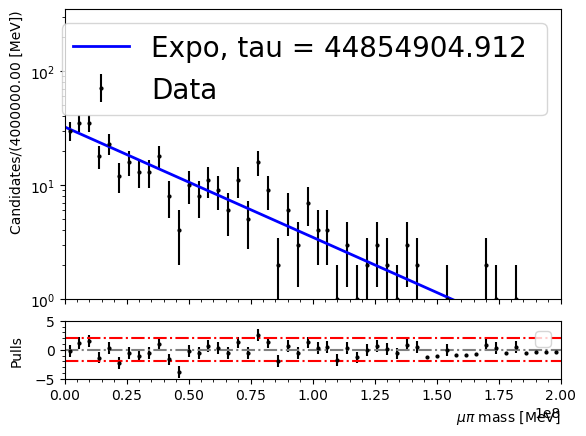

In [255]:
plotsList = {
    "data":{
        "label": "Data",
        "color": "black"
    },

    "fullmodel": {
        # "label": f"Expo, alpha = {result.params[slope_expo_1]['value']:.1f}", 
        "label": f"Expo, tau = { -1/ result.params[slope_expo_1]['value'] :.3f} ", 
        "color":"blue",
    },

}
f,_,_ = plotFit(bkg_pdf_ext_1, data_np, plotsList, x_label="$\mu\\pi$ mass [MeV]", nbins=50, linewidth=0.1, rangeX = fit_window, plot_chi2 = True, logy = True)
plt.legend(loc = 'best', fontsize = 'x-large')
# plt.savefig(f'{plotsPath}/signal_region_fit_toMuPi_JohnsonSU_{region}_region_{bkg_region}_{key}.pdf', dpi = 200)

In [259]:
df_test

,n_hits,tofpet_id,tofpet_channel,timestamp,t_coarse,t_fine,v_coarse,v_fine,value,timestamp_global,...,index_y,track_param,track_id,hitsX,hitsY,track_mean_time,track_hitX,track_hitY,track_last_hitX,track_last_hitY
18,21,"[1, 4, 4, 0, 4, 2, 1, 2, 3, 0, 6, 6, 5, 7, 6, ...","[56, 20, 12, 51, 52, 56, 48, 36, 56, 23, 3, 47...","[0.36406112, 0.3387759, 0.22964606, 0.35876107...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[285, 301, 317, 304, 269, 279, 293, 253, 257, ...","[40, 48, 48, 40, 46, 40, 40, 44, 38, 32, 36, 4...","[57, 45, 49, 51, 47, 47, 56, 49, 49, 51, 48, 4...","[-0.3135891, -0.82231325, 0.24428469, -0.42816...",61420341,...,"[5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20]","[8.250505050505053, -1.1363636363636365, 27.11...",18,"[[12, 3], [8, 6], [7, 7], [15, 1], [10, 5], [1...","[[11, 1], [12, 2], [12, 3], [15, 7], [14, 5], ...",6.14203e+07,"[[12, 3], [8, 6], [7, 7], [15, 1], [10, 5], [1...","[[11, 1], [12, 2], [12, 3], [15, 7], [14, 5], ...","[5, 8]","[16, 8]"
41,12,"[1, 3, 6, 4, 6, 4, 3, 5, 7, 4, 6, 1]","[38, 38, 26, 54, 46, 8, 58, 44, 46, 38, 2, 34]","[0.46687505, 0.30044308, 0.13078116, 0.3160458...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[260, 306, 316, 299, 308, 311, 223, 347, 309, ...","[36, 38, 36, 46, 38, 42, 36, 38, 40, 48, 36, 38]","[56, 64, 56, 55, 44, 56, 47, 62, 49, 49, 50, 58]","[-0.8448553, 1.4276503, 1.8902504, 0.35085836,...",67132904,...,None,None,None,"[[2, 4], [4, 5], [8, 7], [10, 8], [6, 6], [1, 4]]","[[2, 4], [3, 6], [2, 5], [1, 3], [4, 8], [3, 7]]",None,None,None,None,None
60,9,"[4, 3, 4, 5, 6, 7, 6, 1, 6]","[6, 33, 46, 50, 41, 41, 21, 34, 1]","[0.5811783, 0.8478426, 0.85727125, 0.4066967, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1]","[260, 238, 203, 292, 208, 236, 236, 250, 308]","[48, 40, 46, 36, 38, 44, 38, 38, 32]","[46, 57, 49, 52, 46, 43, 44, 55, 42]","[-1.249579, -0.5120435, -1.8308084, 1.0668914,...",73883794,...,"[1, 4, 5, 6, 8]","[10.145454545454545, 0.9090909090909092, 34.94...",60,"[[4, 7], [2, 5], [5, 8], [1, 4]]","[[24, 4], [24, 5], [22, 8], [23, 6], [22, 7]]",7.38838e+07,"[[4, 7], [2, 5], [5, 8], [1, 4]]","[[24, 4], [24, 5], [22, 8], [23, 6], [22, 7]]","[5, 8]","[22, 8]"
105,16,"[6, 1, 7, 6, 4, 3, 1, 4, 4, 7, 4, 5, 7, 7, 6, 5]","[23, 35, 35, 32, 27, 48, 52, 31, 43, 51, 42, 4...","[0.98513347, 0.8066452, 1.1262498, 1.1203352, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[181, 217, 311, 319, 286, 310, 349, 351, 306, ...","[36, 52, 38, 36, 48, 38, 48, 42, 48, 44, 44, 3...","[38, 64, 46, 50, 48, 50, 52, 54, 47, 49, 45, 5...","[-1.4876015, 1.7744374, 1.0992572, 0.35562634,...",87734096,...,None,None,None,"[[13, 4], [15, 6], [12, 4], [16, 6], [13, 5], ...","[[14, 6], [13, 8], [11, 6], [11, 4], [17, 8], ...",None,None,None,None,None
111,13,"[1, 4, 6, 6, 2, 5, 0, 3, 2, 0, 0, 4, 2]","[50, 54, 44, 20, 4, 58, 48, 40, 24, 14, 16, 22...","[0.22612312, 0.6360874, 0.20669346, 0.32734868...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[309, 247, 292, 281, 246, 224, 285, 334, 243, ...","[44, 46, 36, 38, 40, 38, 44, 36, 44, 38, 36, 5...","[46, 51, 53, 44, 54, 54, 52, 55, 50, 45, 54, 5...","[-0.98142, -1.207266, 2.650546, -0.895629, -1....",89316451,...,"[2, 3, 4, 7, 8, 12]","[-1.2000000000000004, -1.085858585858586, 13.0...",111,"[[5, 4], [4, 5], [1, 7], [9, 1], [6, 3], [7, 2...","[[8, 5], [8, 6], [9, 3], [9, 4], [9, 2], [9, 1]]",8.93165e+07,"[[5, 4], [4, 5], [1, 7], [9, 1], [6, 3], [7, 2...","[[8, 5], [8, 6], [9, 3], [9, 4], [9, 2], [9, 1]]","[1, 7]","[8, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180064,11,"[1, 0, 0, 4, 2, 2, 3, 6, 2, 0, 2]","[55, 15, 37, 63, 38, 10, 42, 42, 44, 61, 6]","[0.8881768, 0.988693, 0.99769366, 0.9486484, 1...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]","[211, 180, 200, 195, 276, 290, 349, 317, 362, ...","[40, 34, 44, 52, 40, 42, 42, 34, 38, 38, 40]","[46, 49, 44, 53, 47, 51, 54, 53, 59, 55, 50]","[-1.685942, -0.8972263, -0.1323004, 0.6328642,...",58654948920,...,None,None,None,"[[18, 4], [18, 3], [19, 2], [18, 5], [19, 

In [261]:
df_test.head()

,n_hits,tofpet_id,tofpet_channel,timestamp,t_coarse,t_fine,v_coarse,v_fine,value,timestamp_global,...,index_y,track_param,track_id,hitsX,hitsY,track_mean_time,track_hitX,track_hitY,track_last_hitX,track_last_hitY
18,21,"[1, 4, 4, 0, 4, 2, 1, 2, 3, 0, 6, 6, 5, 7, 6, ...","[56, 20, 12, 51, 52, 56, 48, 36, 56, 23, 3, 47...","[0.36406112, 0.3387759, 0.22964606, 0.35876107...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[285, 301, 317, 304, 269, 279, 293, 253, 257, ...","[40, 48, 48, 40, 46, 40, 40, 44, 38, 32, 36, 4...","[57, 45, 49, 51, 47, 47, 56, 49, 49, 51, 48, 4...","[-0.3135891, -0.82231325, 0.24428469, -0.42816...",61420341,...,"[5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20]","[8.250505050505053, -1.1363636363636365, 27.11...",18,"[[12, 3], [8, 6], [7, 7], [15, 1], [10, 5], [1...","[[11, 1], [12, 2], [12, 3], [15, 7], [14, 5], ...",6.14203e+07,"[[12, 3], [8, 6], [7, 7], [15, 1], [10, 5], [1...","[[11, 1], [12, 2], [12, 3], [15, 7], [14, 5], ...","[5, 8]","[16, 8]"
41,12,"[1, 3, 6, 4, 6, 4, 3, 5, 7, 4, 6, 1]","[38, 38, 26, 54, 46, 8, 58, 44, 46, 38, 2, 34]","[0.46687505, 0.30044308, 0.13078116, 0.3160458...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[260, 306, 316, 299, 308, 311, 223, 347, 309, ...","[36, 38, 36, 46, 38, 42, 36, 38, 40, 48, 36, 38]","[56, 64, 56, 55, 44, 56, 47, 62, 49, 49, 50, 58]","[-0.8448553, 1.4276503, 1.8902504, 0.35085836,...",67132904,...,None,None,None,"[[2, 4], [4, 5], [8, 7], [10, 8], [6, 6], [1, 4]]","[[2, 4], [3, 6], [2, 5], [1, 3], [4, 8], [3, 7]]",None,None,None,None,None
60,9,"[4, 3, 4, 5, 6, 7, 6, 1, 6]","[6, 33, 46, 50, 41, 41, 21, 34, 1]","[0.5811783, 0.8478426, 0.85727125, 0.4066967, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1]","[260, 238, 203, 292, 208, 236, 236, 250, 308]","[48, 40, 46, 36, 38, 44, 38, 38, 32]","[46, 57, 49, 52, 46, 43, 44, 55, 42]","[-1.249579, -0.5120435, -1.8308084, 1.0668914,...",73883794,...,"[1, 4, 5, 6, 8]","[10.145454545454545, 0.9090909090909092, 34.94...",60,"[[4, 7], [2, 5], [5, 8], [1, 4]]","[[24, 4], [24, 5], [22, 8], [23, 6], [22, 7]]",7.38838e+07,"[[4, 7], [2, 5], [5, 8], [1, 4]]","[[24, 4], [24, 5], [22, 8], [23, 6], [22, 7]]","[5, 8]","[22, 8]"
105,16,"[6, 1, 7, 6, 4, 3, 1, 4, 4, 7, 4, 5, 7, 7, 6, 5]","[23, 35, 35, 32, 27, 48, 52, 31, 43, 51, 42, 4...","[0.98513347, 0.8066452, 1.1262498, 1.1203352, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[181, 217, 311, 319, 286, 310, 349, 351, 306, ...","[36, 52, 38, 36, 48, 38, 48, 42, 48, 44, 44, 3...","[38, 64, 46, 50, 48, 50, 52, 54, 47, 49, 45, 5...","[-1.4876015, 1.7744374, 1.0992572, 0.35562634,...",87734096,...,None,None,None,"[[13, 4], [15, 6], [12, 4], [16, 6], [13, 5], ...","[[14, 6], [13, 8], [11, 6], [11, 4], [17, 8], ...",None,None,None,None,None
111,13,"[1, 4, 6, 6, 2, 5, 0, 3, 2, 0, 0, 4, 2]","[50, 54, 44, 20, 4, 58, 48, 40, 24, 14, 16, 22...","[0.22612312, 0.6360874, 0.20669346, 0.32734868...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[309, 247, 292, 281, 246, 224, 285, 334, 243, ...","[44, 46, 36, 38, 40, 38, 44, 36, 44, 38, 36, 5...","[46, 51, 53, 44, 54, 54, 52, 55, 50, 45, 54, 5...","[-0.98142, -1.207266, 2.650546, -0.895629, -1....",89316451,...,"[2, 3, 4, 7, 8, 12]","[-1.2000000000000004, -1.085858585858586, 13.0...",111,"[[5, 4], [4, 5], [1, 7], [9, 1], [6, 3], [7, 2...","[[8, 5], [8, 6], [9, 3], [9, 4], [9, 2], [9, 1]]",8.93165e+07,"[[5, 4], [4, 5], [1, 7], [9, 1], [6, 3], [7, 2...","[[8, 5], [8, 6], [9, 3], [9, 4], [9, 2], [9, 1]]","[1, 7]","[8, 6]"
